### 1차 파생변수 만들기
1. trial_diff = 첫방문일자 - 3일체험등록일자 | 1 
2. 방문일자 -> year,month,day,weekday  | 4
3. weekday -> 주말여부로 weektype       | 1
4. first_enter_time,last_leave_time -> hour , min | 4
5. site_id -> 원핫인코딩
### 삭제할 컬럼
방문일자(date),머무른시간(stay_time)-> stay_time_second를 쓸거임,first_enter_time,last_leave_time,user_uuid,trial_date

### 2차 파생변수

1. 인당 공유오피스를 방문한 횟수 -> total_visit_count
2. 사이클릭 인코딩(시간데이터)
3. 인당 방문한 공유오피스 종류?-> unique_site_count 
4. site_id와 면적 매핑 -> area_pyeong


### 3차 파생변수
1. 사이클릭 인코딩에서 cos삭제(last_leave_time,first_enter_time)

| **단계**     | **항목**                                 | **설명**                                                    | **결과 변수**            |
|--------------|------------------------------------------|------------------------------------------------------------|--------------------------|
| 1차 파생변수  | trial_diff                               | 첫방문일자에서 3일체험등록일자를 뺀 차이, 값은 1로 설정     | trial_diff               |
|              | 방문일자 -> year, month, day, weekday  | 방문일자에서 연도, 월, 일, 요일 정보 추출                  | year, month, day, weekday|
|              | weekday -> 주말여부로 weektype          | 요일에 따라 주말(5, 6)을 `1`, 평일(0-4)을 `0`으로 구분   | weektype                 |
|              | first_enter_time, last_leave_time -> hour, min | 첫 입장 시간과 마지막 퇴장 시간에서 시간(hour)과 분(min) 추출 | first_enter_hour, first_enter_min, last_leave_hour, last_leave_min |
| 삭제할 컬럼   | 방문일자(date)                           | 분석에 필요 없는 방문일자                                  | 삭제                     |
|              | 머무른시간(stay_time)                   | 새로운 변수 `stay_time_second`로 대체                     | 삭제                     |
|              | first_enter_time                         | 첫 입장 시간은 이제 `hour`와 `min`으로 분리되므로 삭제   | 삭제                     |
|              | last_leave_time                          | 마지막 퇴장 시간은 `hour`와 `min`으로 분리되므로 삭제     | 삭제                     |
|              | user_uuid                                | 더 이상 사용하지 않음                                      | 삭제                     |
|              | trial_date                               | 더 이상 사용하지 않음                                      | 삭제                     |
| 2차 파생변수  | 인당 공유오피스를 방문한 횟수            | 사용자별로 공유오피스 방문 횟수를 계산                    | total_visit_count        |
|              | 사이클릭 인코딩(시간데이터)             | 시간 데이터를 사이클릭 인코딩하여 주기적인 변화를 반영    | hour_sin, hour_cos       |
|              | 인당 방문한 공유오피스 종류             | 각 사용자가 방문한 공유오피스의 종류 수를 계산            | unique_site_count        |
| 3차 파생변수  | 사이클릭 인코딩에서 cos 삭제            | `first_enter_min_time`, `last_leave_min_time`에 대해 `cos` 값 삭제  | 삭제                     |



In [1]:
# 데이터 분석 관련 라이브러리
import pandas as pd  # 데이터 프레임 처리
import numpy as np  # 배열, 행렬 연산

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt  # 기본적인 시각화
import seaborn as sns  # 고급 시각화
import matplotlib.font_manager as fm  # 폰트 설정
from matplotlib import rcParams  # 설정 관리

# 맥북에서 한글 설정 (matplotlib에서 한글 깨짐 방지)
plt.rcParams['font.family'] = 'AppleGothic'  # 맥북에서 기본 한글 폰트 적용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 머신러닝 관련 라이브러리
from sklearn.model_selection import train_test_split  # 데이터 분할
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # 스케일러
from sklearn.linear_model import LinearRegression, LogisticRegression  # 선형 회귀, 로지스틱 회귀
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor  # 결정 트리
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # 랜덤 포레스트
from sklearn.svm import SVC, SVR  # 서포트 벡터 머신
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix

# 통계 관련 라이브러리
import statsmodels.api as sm  # 통계 모델링
import scipy.stats as stats  # 통계 함수

# 기타 라이브러리
import os  # 운영체제 관련 기능
import sys  # 시스템 관련 기능
import re  # 정규 표현식
import json  # JSON 파일 처리
import datetime  # 날짜 및 시간 처리
import pickle  # 객체 직렬화 및 역직렬화
import requests  # HTTP 요청
import random  # 난수 생성
import math  # 수학 함수


In [2]:
merge_df = pd.read_csv('/Users/parkjunhyeok/Desktop/codit/프로젝트/중급2프로젝트/데이터_0.csv')

## 1차 모델링
- 데이터 전처리

In [3]:
merge_df.drop('Unnamed: 0', axis=1, inplace=True)   
merge_df.head()

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,trial_date,is_payment,count,total_visit_count
0,1,2023-12-23,01:11:19.983486,4279,2023-12-23 16:11:25.345793,2023-12-23 17:25:32.233995,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-23,1,4.0,3
1,1,2023-12-24,04:35:10.361341,16510,2023-12-24 16:10:45.668026,2023-12-24 20:53:34.842447,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-23,1,8.0,3
2,1,2023-12-25,02:09:54.117163,7794,2023-12-25 10:19:47.087268,2023-12-25 12:39:51.221372,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-23,1,6.0,3
3,1,2023-12-23,04:37:36.134901,16656,2023-12-23 14:49:40.302823,2023-12-23 19:27:39.406803,ba49324f-d317-4053-adf9-2b17b3f07594,2023-12-23,1,4.0,3
4,3,2023-12-26,04:32:05.289251,16325,2023-12-26 14:57:10.220793,2023-12-26 19:34:36.971542,ba49324f-d317-4053-adf9-2b17b3f07594,2023-12-23,1,NaN,3


In [4]:
# 결제한 유저의 비율
merge_df.drop_duplicates(subset='user_uuid')['is_payment'].value_counts(normalize=True)

is_payment
0    0.613273
1    0.386727
Name: proportion, dtype: float64

### 결측치 처리(출퇴실 시간)

In [5]:
# first_enter_time과 last_leave_time이 결측치 인 경우가 있다. (랜덤값으로 대치하거나 삭제하는 방법이 있다.)
merge_df[merge_df['first_enter_time'].isnull()].head()

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,trial_date,is_payment,count,total_visit_count
317,1,2021-06-03,03:43:06.377172,13386,NaN,NaN,91bded23-9587-46f8-91bf-62872c06f95e,2021-05-31,1,NaN,3
318,4,2021-06-01,06:51:00.013723,24660,NaN,NaN,91bded23-9587-46f8-91bf-62872c06f95e,2021-05-31,1,6.0,3
319,4,2021-06-02,00:19:07.855184,1147,NaN,NaN,91bded23-9587-46f8-91bf-62872c06f95e,2021-05-31,1,NaN,3
694,3,2021-06-25,01:24:23.577860,5063,NaN,NaN,67a52b62-0441-4b12-94a5-3e601bf0f4c0,2021-06-23,1,2.0,2
695,3,2021-06-24,02:17:26.786498,8246,NaN,NaN,67a52b62-0441-4b12-94a5-3e601bf0f4c0,2021-06-23,1,6.0,2


In [6]:
merge_df.isnull().sum() 

site_id                 0
date                    0
stay_time               0
stay_time_second        0
first_enter_time      520
last_leave_time       520
user_uuid               0
trial_date              0
is_payment              0
count                2436
total_visit_count       0
dtype: int64

In [7]:
merge_df.dropna(subset=['first_enter_time'], inplace=True)

In [8]:
merge_df.isnull().sum()

site_id                 0
date                    0
stay_time               0
stay_time_second        0
first_enter_time        0
last_leave_time         0
user_uuid               0
trial_date              0
is_payment              0
count                2365
total_visit_count       0
dtype: int64

### 중앙값으로 대치(count컬럼)

In [9]:
merge_df['count'].fillna(merge_df['count'].median(), inplace=True)

/var/folders/j6/q47by8d57xv9mxr1cgqzpp_w0000gn/T/ipykernel_19593/1405832037.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merge_df['count'].fillna(merge_df['count'].median(), inplace=True)


In [10]:
merge_df.isnull().sum()

site_id              0
date                 0
stay_time            0
stay_time_second     0
first_enter_time     0
last_leave_time      0
user_uuid            0
trial_date           0
is_payment           0
count                0
total_visit_count    0
dtype: int64

In [ ]:
import pandas as pd

# 1. date와 trial_date 컬럼을 datetime 타입으로 변환
merge_df['date'] = pd.to_datetime(merge_df['date'])
merge_df['trial_date'] = pd.to_datetime(merge_df['trial_date'])

# 2. date 컬럼에서 년, 월, 일을 분리하여 새 컬럼 생성 (예: date_year, date_month, date_day)
merge_df['date_year'] = merge_df['date'].dt.year
merge_df['date_month'] = merge_df['date'].dt.month
merge_df['date_day'] = merge_df['date'].dt.day
merge_df['weekday'] = merge_df['date'].dt.weekday # date 컬럼의 요일을 숫자로 추출 (월:0 ~ 일:6)

# 주말(토,일)은 5 이상, 평일은 그 외
merge_df['week_type'] = merge_df['weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

merge_df['week_type'] = merge_df['week_type'].map({'Weekend': 1, 'Weekday': 0})
# 4. first_enter_time과 last_leave_time을 datetime 타입으로 변환
def parse_mixed_datetime(x):
    # 마이크로초가 포함된 형식 먼저 시도
    try:
        return pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f")
    except ValueError:
        # 마이크로초가 없는 형식으로 변환 시도
        return pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S")

# 각 컬럼에 대해 변환 적용
merge_df['first_enter_time'] = merge_df['first_enter_time'].apply(parse_mixed_datetime)
merge_df['last_leave_time'] = merge_df['last_leave_time'].apply(parse_mixed_datetime)


# 각 user_uuid별 첫 방문 날짜를 date 컬럼에서 구함 (최소값)
merge_df['first_visit_date'] = merge_df.groupby('user_uuid')['date'].transform('min')

# trial_date와 각 사용자의 첫 방문 날짜의 차이를 일(day) 단위로 계산하여 새로운 컬럼에 저장
merge_df['trial_first_diff'] = (merge_df['first_visit_date']-merge_df['trial_date']).dt.days


# 5. first_enter_time과 last_leave_time에서 시(hour)와 분(minute) 추출하여 새 컬럼 생성
merge_df['first_enter_hour'] = merge_df['first_enter_time'].dt.hour
merge_df['first_enter_minute'] = merge_df['first_enter_time'].dt.minute

merge_df['last_leave_hour'] = merge_df['last_leave_time'].dt.hour
merge_df['last_leave_minute'] = merge_df['last_leave_time'].dt.minute




In [12]:
merge_df.head()

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,trial_date,is_payment,count,...,date_month,date_day,weekday,week_type,first_visit_date,trial_first_diff,first_enter_hour,first_enter_minute,last_leave_hour,last_leave_minute
0,1,2023-12-23,01:11:19.983486,4279,2023-12-23 16:11:25.345793,2023-12-23 17:25:32.233995,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-23,1,4.0,...,12,23,5,1,2023-12-23,0,16,11,17,25
1,1,2023-12-24,04:35:10.361341,16510,2023-12-24 16:10:45.668026,2023-12-24 20:53:34.842447,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-23,1,8.0,...,12,24,6,1,2023-12-23,0,16,10,20,53
2,1,2023-12-25,02:09:54.117163,7794,2023-12-25 10:19:47.087268,2023-12-25 12:39:51.221372,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-23,1,6.0,...,12,25,0,0,2023-12-23,0,10,19,12,39
3,1,2023-12-23,04:37:36.134901,16656,2023-12-23 14:49:40.302823,2023-12-23 19:27:39.406803,ba49324f-d317-4053-adf9-2b17b3f07594,2023-12-23,1,4.0,...,12,23,5,1,2023-12-23,0,14,49,19,27
4,3,2023-12-26,04:32:05.289251,16325,2023-12-26 14:57:10.220793,2023-12-26 19:34:36.971542,ba49324f-d317-4053-adf9-2b17b3f07594,2023-12-23,1,6.0,...,12,26,1,0,2023-12-23,0,14,57,19,34


In [13]:
merge_df.columns

Index(['site_id', 'date', 'stay_time', 'stay_time_second', 'first_enter_time',
       'last_leave_time', 'user_uuid', 'trial_date', 'is_payment', 'count',
       'total_visit_count', 'date_year', 'date_month', 'date_day', 'weekday',
       'week_type', 'first_visit_date', 'trial_first_diff', 'first_enter_hour',
       'first_enter_minute', 'last_leave_hour', 'last_leave_minute'],
      dtype='object')

In [14]:
# 2024년 데이터 삭제(이상치)
merge_df = merge_df[merge_df['date_year'] != 2024]
# 컬럼삭제
merge_df.drop(columns=['first_enter_time', 'last_leave_time','trial_date','first_visit_date','date','stay_time','first_visit_date'],axis=1 ,inplace=True)

In [15]:
merge_df.to_csv('./데이터1_1.csv', index=False)

In [16]:
merge_df.drop(columns='user_uuid',axis=1,inplace=True)

In [17]:
# site_id 원핫 인코딩
df = pd.get_dummies(merge_df, columns=['site_id'], prefix='site')

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10546 entries, 0 to 11079
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stay_time_second    10546 non-null  int64  
 1   is_payment          10546 non-null  int64  
 2   count               10546 non-null  float64
 3   total_visit_count   10546 non-null  int64  
 4   date_year           10546 non-null  int32  
 5   date_month          10546 non-null  int32  
 6   date_day            10546 non-null  int32  
 7   weekday             10546 non-null  int32  
 8   week_type           10546 non-null  int64  
 9   trial_first_diff    10546 non-null  int64  
 10  first_enter_hour    10546 non-null  int32  
 11  first_enter_minute  10546 non-null  int32  
 12  last_leave_hour     10546 non-null  int32  
 13  last_leave_minute   10546 non-null  int32  
 14  site_1              10546 non-null  bool   
 15  site_2              10546 non-null  bool   
 16  site_3   

In [18]:
df.columns

Index(['stay_time_second', 'is_payment', 'count', 'total_visit_count',
       'date_year', 'date_month', 'date_day', 'weekday', 'week_type',
       'trial_first_diff', 'first_enter_hour', 'first_enter_minute',
       'last_leave_hour', 'last_leave_minute', 'site_1', 'site_2', 'site_3',
       'site_4', 'site_5', 'site_6', 'site_17', 'site_47', 'site_49'],
      dtype='object')

### 1차 모델 적용(랜덤포레스트, Xgboost,lightGBM)

In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.metrics import average_precision_score, confusion_matrix, classification_report, accuracy_score

# 타겟변수와 입력 변수 정의 (여기서는 is_payment가 타겟이라고 가정)
X = df.drop(columns=['is_payment'])
y = df['is_payment']

# 학습/테스트셋 분할 (stratify 사용으로 클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# SMOTETomek 객체 생성 및 학습셋에 오버샘플링/언더샘플링 적용
smt = SMOTETomek(random_state=42)
X_train_over, y_train_over = smt.fit_resample(X_train, y_train)

# 결과 확인
print("오버샘플링 전 X_train 데이터 크기:", X_train.shape)
print("오버샘플링 후 X_train 데이터 크기:", X_train_over.shape)
print("오버샘플링 전 y_train 데이터 크기:", y_train.shape)
print("오버샘플링 후 y_train 데이터 크기:", y_train_over.shape)

### Logistic Regression ###
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train_over, y_train_over)
# 예측 확률 (양성 클래스 확률)
y_pred_lr_prob = lr_clf.predict_proba(X_test)[:, 1]
aucpr_lr = average_precision_score(y_test, y_pred_lr_prob)
# 예측 클래스 (혼동행렬 및 리포트를 위한 예측 결과)
y_pred_lr = lr_clf.predict(X_test)
# Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print("Logistic Regression AUC-PR:", aucpr_lr)
print("Logistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("Logistic Regression Classifixgbion Report:")
print(classification_report(y_test, y_pred_lr))


### RandomForestClassifier ###
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_over, y_train_over)
# 예측 확률 (양성 클래스 확률)
y_pred_rf_prob = rf_clf.predict_proba(X_test)[:, 1]
aucpr_rf = average_precision_score(y_test, y_pred_rf_prob)
# 예측 클래스 (혼동행렬 및 리포트를 위한 예측 결과)
y_pred_rf = rf_clf.predict(X_test)
# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("RandomForest AUC-PR:", aucpr_rf)
print("RandomForest Accuracy:", accuracy_rf)
print("RandomForest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("RandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf))


### LightGBM Classifier ###
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(random_state=42)
lgbm_clf.fit(X_train_over, y_train_over)
y_pred_lgbm_prob = lgbm_clf.predict_proba(X_test)[:, 1]
aucpr_lgbm = average_precision_score(y_test, y_pred_lgbm_prob)
y_pred_lgbm = lgbm_clf.predict(X_test)
# Accuracy
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)

print("LightGBM AUC-PR:", aucpr_lgbm)
print("LightGBM Accuracy:", accuracy_lgbm)
print("LightGBM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm))
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm))


### XGBoost Classifier ###
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_over, y_train_over)
y_pred_xgb_prob = xgb_clf.predict_proba(X_test)[:, 1]
aucpr_xgb = average_precision_score(y_test, y_pred_lr_prob)
y_pred_xgb = xgb_clf.predict(X_test)
# Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print("XGBoost AUC-PR:", aucpr_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


### catboost Classifier ###
from catboost import CatBoostClassifier

cat_clf = CatBoostClassifier(random_state=42)
cat_clf.fit(X_train_over, y_train_over)
y_pred_cat_prob = cat_clf.predict_proba(X_test)[:, 1]
aucpr_cat = average_precision_score(y_test, y_pred_cat_prob)
y_pred_cat = cat_clf.predict(X_test)
# Accuracy
accuracy_cat = accuracy_score(y_test, y_pred_cat)

print("CatBoost AUC-PR:", aucpr_cat)
print("CatBoost Accuracy:", accuracy_cat)
print("CatBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_cat))
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))


오버샘플링 전 X_train 데이터 크기: (8436, 22)
오버샘플링 후 X_train 데이터 크기: (8348, 22)
오버샘플링 전 y_train 데이터 크기: (8436,)
오버샘플링 후 y_train 데이터 크기: (8348,)


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression AUC-PR: 0.4631881733615948
Logistic Regression Accuracy: 0.5549763033175356
Logistic Regression Confusion Matrix:
[[654 601]
 [338 517]]
Logistic Regression Classifixgbion Report:
              precision    recall  f1-score   support

           0       0.66      0.52      0.58      1255
           1       0.46      0.60      0.52       855

    accuracy                           0.55      2110
   macro avg       0.56      0.56      0.55      2110
weighted avg       0.58      0.55      0.56      2110

RandomForest AUC-PR: 0.5438387636647427
RandomForest Accuracy: 0.6274881516587678
RandomForest Confusion Matrix:
[[947 308]
 [478 377]]
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.75      0.71      1255
           1       0.55      0.44      0.49       855

    accuracy                           0.63      2110
   macro avg       0.61      0.60      0.60      2110
weighted avg       0.62      

/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:43:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


3:	learn: 0.6855195	total: 13.6ms	remaining: 3.39s
4:	learn: 0.6834542	total: 17ms	remaining: 3.39s
5:	learn: 0.6805500	total: 19.4ms	remaining: 3.22s
6:	learn: 0.6787396	total: 21.9ms	remaining: 3.1s
7:	learn: 0.6768790	total: 24.3ms	remaining: 3.01s
8:	learn: 0.6747911	total: 26.8ms	remaining: 2.95s
9:	learn: 0.6735111	total: 29.2ms	remaining: 2.89s
10:	learn: 0.6719967	total: 32.3ms	remaining: 2.9s
11:	learn: 0.6702826	total: 35.4ms	remaining: 2.91s
12:	learn: 0.6653771	total: 37.7ms	remaining: 2.86s
13:	learn: 0.6640236	total: 40.2ms	remaining: 2.83s
14:	learn: 0.6629451	total: 43ms	remaining: 2.82s
15:	learn: 0.6616598	total: 46.1ms	remaining: 2.83s
16:	learn: 0.6584609	total: 50.3ms	remaining: 2.91s
17:	learn: 0.6571990	total: 53.5ms	remaining: 2.92s
18:	learn: 0.6563097	total: 56ms	remaining: 2.89s
19:	learn: 0.6551019	total: 58.2ms	remaining: 2.85s
20:	learn: 0.6541370	total: 61.8ms	remaining: 2.88s
21:	learn: 0.6532532	total: 66.1ms	remaining: 2.94s
22:	learn: 0.6522499	total:

#### 속성중요도 보기

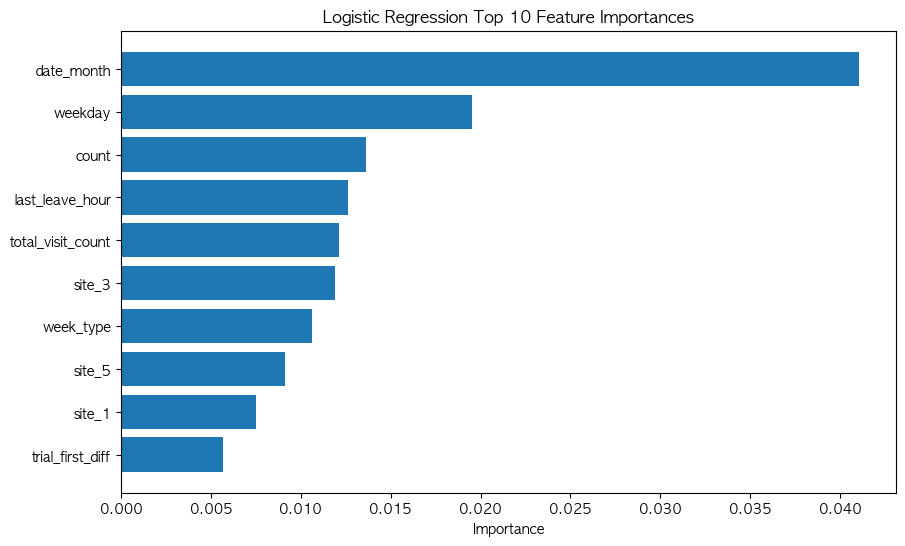

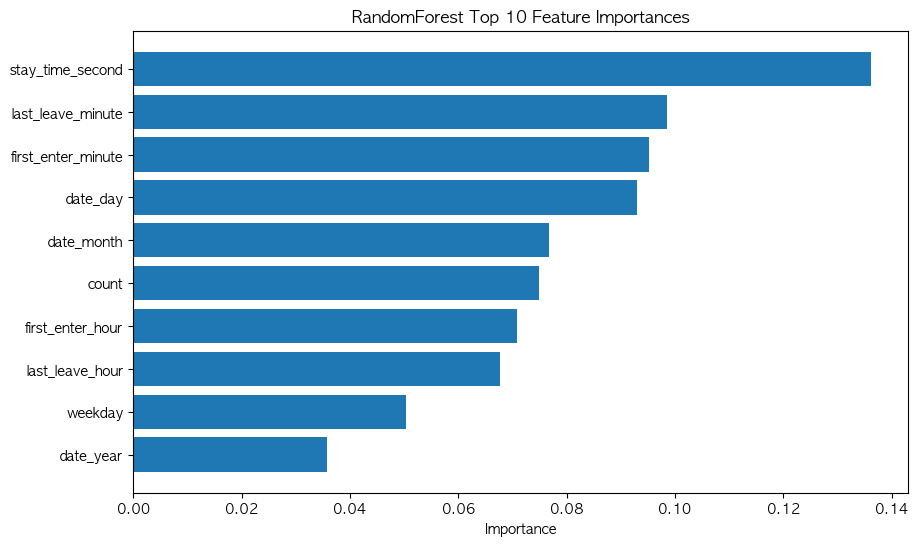

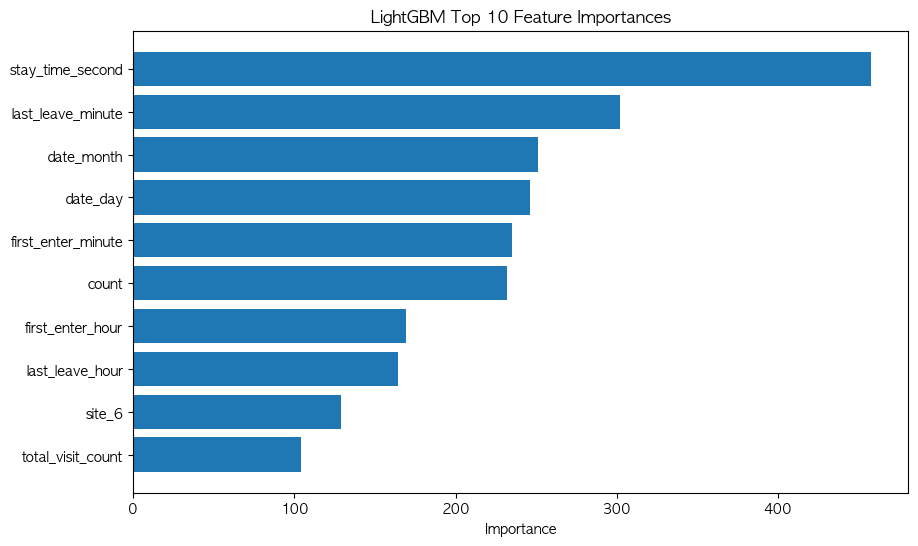

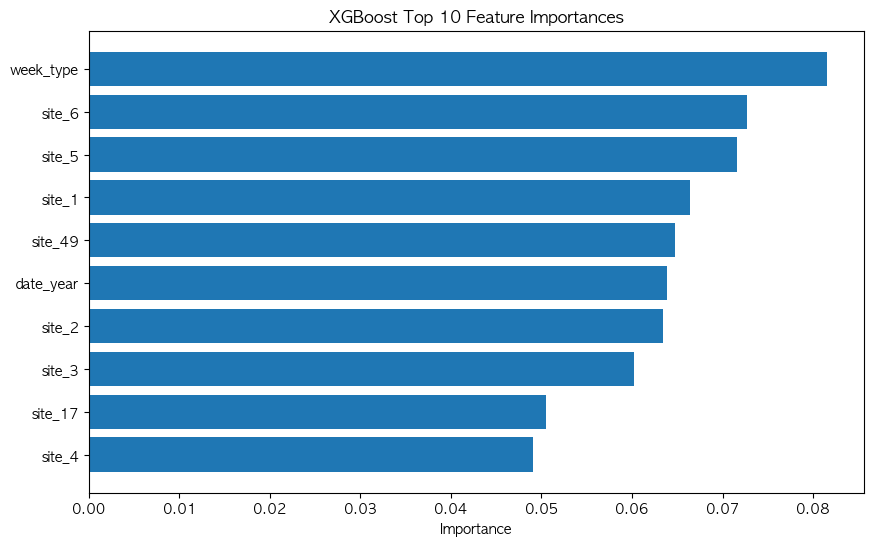

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# 로지스틱 회귀: 회귀 계수를 사용하여 중요도 계산
lr_coefficients = lr_clf.coef_.flatten()
lr_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr_coefficients})
lr_df['Importance'] = np.abs(lr_df['Coefficient'])  # 계수의 절댓값을 중요도로 사용

# 로지스틱 회귀: 중요도를 기준으로 내림차순 정렬 후 상위 10개 출력
lr_df_sorted = lr_df.sort_values(by='Importance', ascending=False).head(10)

# 상위 10개 로지스틱 회귀 피처 중요도
plt.figure(figsize=(10, 6))
plt.barh(lr_df_sorted['Feature'][::-1], lr_df_sorted['Importance'][::-1])
plt.xlabel("Importance")
plt.title("Logistic Regression Top 10 Feature Importances")
plt.show()

# 랜덤 포레스트: feature_importances_ 사용
rf_importances = rf_clf.feature_importances_
rf_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_importances})

# 랜덤 포레스트: 중요도를 기준으로 내림차순 정렬 후 상위 10개 출력
rf_df_sorted = rf_df.sort_values(by='Importance', ascending=False).head(10)

# 상위 10개 랜덤 포레스트 피처 중요도
plt.figure(figsize=(10, 6))
plt.barh(rf_df_sorted['Feature'][::-1], rf_df_sorted['Importance'][::-1])
plt.xlabel("Importance")
plt.title("RandomForest Top 10 Feature Importances")
plt.show()

# LightGBM: feature_importances_ 사용
lgbm_importances = lgbm_clf.feature_importances_
lgbm_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': lgbm_importances})

# LightGBM: 중요도를 기준으로 내림차순 정렬 후 상위 10개 출력
lgbm_df_sorted = lgbm_df.sort_values(by='Importance', ascending=False).head(10)

# 상위 10개 LightGBM 피처 중요도
plt.figure(figsize=(10, 6))
plt.barh(lgbm_df_sorted['Feature'][::-1], lgbm_df_sorted['Importance'][::-1])
plt.xlabel("Importance")
plt.title("LightGBM Top 10 Feature Importances")
plt.show()

# XGBoost: feature_importances_ 사용
xgb_importances = xgb_clf.feature_importances_
xgb_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_importances})

# XGBoost: 중요도를 기준으로 내림차순 정렬 후 상위 10개 출력
xgb_df_sorted = xgb_df.sort_values(by='Importance', ascending=False).head(10)

# 상위 10개 XGBoost 피처 중요도
plt.figure(figsize=(10, 6))
plt.barh(xgb_df_sorted['Feature'][::-1], xgb_df_sorted['Importance'][::-1])
plt.xlabel("Importance")
plt.title("XGBoost Top 10 Feature Importances")
plt.show()


In [ ]:
merge_df.to_csv('./데이터1차.csv')

In [97]:
merge_df = pd.read_csv('./데이터1차.csv')

In [98]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stay_time_second    10546 non-null  int64  
 1   is_payment          10546 non-null  int64  
 2   count               10546 non-null  float64
 3   total_visit_count   10546 non-null  int64  
 4   date_year           10546 non-null  int64  
 5   date_month          10546 non-null  int64  
 6   date_day            10546 non-null  int64  
 7   weekday             10546 non-null  int64  
 8   week_type           10546 non-null  int64  
 9   trial_first_diff    10546 non-null  int64  
 10  first_enter_hour    10546 non-null  int64  
 11  first_enter_minute  10546 non-null  int64  
 12  last_leave_hour     10546 non-null  int64  
 13  last_leave_minute   10546 non-null  int64  
 14  site_1              10546 non-null  bool   
 15  site_2              10546 non-null  bool   
 16  site

In [99]:
merge_df = pd.read_csv('./데이터1_1.csv')

## 2차 모델링
- 날짜 데이터 사이클릭 인코딩, 파생변수 추가

In [100]:
merge_df = pd.read_csv('./데이터1_1.csv')

#### 파생변수추가 및 사이클릭 인코딩

In [101]:
# site_id별 area_pyeong 매핑 딕셔너리 정의
area_mapping = {
    1: 50,
    2: 100,
    3: 150,
    4: 100,
    5: 150,
    6: 150,
    17: 50,
    47: 50,
    49: 50
}

# site_id 컬럼을 기준으로 area_pyeong 컬럼 추가
merge_df['area_pyeong'] = merge_df['site_id'].map(area_mapping)

# user_uuid별 고유 site_id의 수 계산
unique_site_count = merge_df.groupby('user_uuid')['site_id'].nunique().reset_index(name='unique_site_count')

# 계산 결과를 원본 데이터프레임에 병합(필요한 경우)
merge_df = merge_df.merge(unique_site_count, on='user_uuid', how='left')

# 2. date_year 컬럼에 대해 레이블 인코딩 적용 (사이클릭 인코딩 대신)
#    예: 2022 -> 0, 2023 -> 1, ... 등으로 매핑됨
merge_df['date_year_le'] = merge_df['date_year'].rank(method='dense', ascending=True).astype(int)


# 2. 사이클릭 인코딩 함수 정의:
def add_cyclic_features(df, col, period):
    """
    df: 데이터프레임
    col: 사이클릭 인코딩을 적용할 컬럼명 (숫자형이어야 함)
    period: 해당 컬럼의 주기 (예: month는 12, hour는 24 등)
    """
    sin_col = col + '_sin'
    cos_col = col + '_cos'
    df[sin_col] = np.sin(2 * np.pi * df[col] / period)
    df[cos_col] = np.cos(2 * np.pi * df[col] / period)
    return df

# 3. 각 컬럼에 대해 사이클릭 인코딩 적용

# date_month: 12개월 주기
df_2 = add_cyclic_features(merge_df, 'date_month', 12)

# date_day: 일반적으로 한 달 최대 31일이므로
df_2 = add_cyclic_features(merge_df, 'date_day', 31)

# first_enter_hour: 24시간 주기
df_2 = add_cyclic_features(merge_df, 'first_enter_hour', 24)

# first_enter_minute: 60분 주기
df_2 = add_cyclic_features(merge_df, 'first_enter_minute', 60)

# last_leave_hour: 24시간 주기
df_2 = add_cyclic_features(merge_df, 'last_leave_hour', 24)

# last_leave_minute: 60분 주기
df_2 = add_cyclic_features(merge_df, 'last_leave_minute', 60)

# last_leave_minute: 7분 주기
df_2 = add_cyclic_features(merge_df, 'weekday', 7)

# site_id 원핫 인코딩
df_2 = pd.get_dummies(merge_df, columns=['site_id'], prefix='site')

In [102]:
df_2

,stay_time_second,user_uuid,is_payment,count,total_visit_count,date_year,date_month,date_day,weekday,week_type,trial_first_diff,first_enter_hour,first_enter_minute,last_leave_hour,last_leave_minute,area_pyeong,unique_site_count,date_year_le,date_month_sin,date_month_cos,date_day_sin,date_day_cos,first_enter_hour_sin,first_enter_hour_cos,first_enter_minute_sin,first_enter_minute_cos,last_leave_hour_sin,last_leave_hour_cos,last_leave_minute_sin,last_leave_minute_cos,weekday_sin,weekday_cos,site_1,site_2,site_3,site_4,site_5,site_6,site_17,site_47,site_49
0,4279,939fc566-61cd-47f0-a3ce-e2936fdcff73,1,4.0,3,2023,12,23,5,1,0,16,11,17,25,50,1,3,-2.449294e-16,1.0,-0.998717,-0.050649,-8.660254e-01,-0.500000,0.913545,4.067366e-01,-9.659258e-01,-2.588190e-01,0.500000,-0.866025,-0.974928,-0.222521,True,False,False,False,False,False,False,False,False
1,16510,939fc566-61cd-47f0-a3ce-e2936fdcff73,1,8.0,3,2023,12,24,6,1,0,16,10,20,53,50,1,3,-2.449294e-16,1.0,-0.988468,0.151428,-8.660254e-01,-0.500000,0.866025,5.000000e-01,-8.660254e-01,5.000000e-01,-0.669131,0.743145,-0.781831,0.623490,True,False,False,False,False,False,False,False,False
2,7794,939fc566-61cd-47f0-a3ce-e2936fdcff73,1,6.0,3,2023,12,25,0,0,0,10,19,12,39,50,1,3,-2.449294e-16,1.0,-0.937752,0.347305,5.000000e-01,-0.866025,0.913545,-4.067366e-01,1.224647e-16,-1.000000e+00,-0.809017,-0.587785,0.000000,1.000000,True,False,False,False,False,False,False,False,False
3,16656,ba49324f-d317-4053-adf9-2b17b3f07594,1,4.0,3,2023,12,23,5,1,0,14,49,19,27,50,3,3,-2.449294e-16,1.0,-0.998717,-0.050649,-5.000000e-01,-0.866025,-0.913545,4.067366e-01,-9.659258e-01,2.588190e-01,0.309017,-0.951057,-0.974928,-0.222521,True,False,False,False,False,False,False,False,False
4,16325,ba49324f-d317-4053-adf9-2b17b3f07594,1,6.0,3,2023,12,26,1,0,0,14,57,19,34,150,3,3,-2.449294e-16,1.0,-0.848644,0.528964,-5.000000e-01,-0.866025,-0.309017,9.510565e-01,-9.659258e-01,2.588190e-01,-0.406737,-0.913545,0.781831,0.623490,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10541,24479,766221e7-a753-444f-aa5a-ae76ce86d3fd,1,12.0,2,2022,6,16,3,0,1,11,0,18,23,150,1,2,1.224647e-16,-1.0,-0.101168,-0.994869,2.588190e-01,-0.965926,0.000000,1.000000e+00,-1.000000e+00,-1.836970e-16,0.669131,-0.743145,0.433884,-0.900969,False,False,False,False,False,True,False,False,False
10542,5326,0a70277f-a7f9-401c-95fa-ed6d96ee32e0,1,6.0,2,2022,6,17,4,0,1,17,15,18,56,150,1,2,1.224647e-16,-1.0,-0.299363,-0.954139,-9.659258e-01,-0.258819,1.000000,2.832769e-16,-1.000000e+00,-1.836970e-16,-0.406737,0.913545,-0.433884,-0.900969,False,False,False,False,False,True,False,False,False
10543,18483,0a70277f-a7f9-401c-95fa-ed6d96ee32e0,1,12.0,2,2022,6,16,3,0,1,12,52,18,23,150,1,2,1.224647e-16,-1.0,-0.101168,-0.994869,1.224647e-16,-1.000000,-0.743145,6.691306e-01,-1.000000e+00,-1.836970e-16,0.669131,-0.743145,0.433884,-0.900969,False,False,False,False,False,True,False,False,False
10544,23429,576473bb-0647-483e-b06a-a5ff6491b08b,1,6.0,1,2023,2,6,0,0,3,10,14,16,52,150,1,3,8.660254e-01,0.5,0.937752,0.347305,5.000000e-01,-0.866025,0.994522,1.045285e-01,-8.660254e-01,-5.000000e-01,-0.743145,0.669131,0.000000,1.000000,False,False,False,False,False,True,False,False,False


In [103]:
df_2.columns

Index(['stay_time_second', 'user_uuid', 'is_payment', 'count',
       'total_visit_count', 'date_year', 'date_month', 'date_day', 'weekday',
       'week_type', 'trial_first_diff', 'first_enter_hour',
       'first_enter_minute', 'last_leave_hour', 'last_leave_minute',
       'area_pyeong', 'unique_site_count', 'date_year_le', 'date_month_sin',
       'date_month_cos', 'date_day_sin', 'date_day_cos',
       'first_enter_hour_sin', 'first_enter_hour_cos',
       'first_enter_minute_sin', 'first_enter_minute_cos',
       'last_leave_hour_sin', 'last_leave_hour_cos', 'last_leave_minute_sin',
       'last_leave_minute_cos', 'weekday_sin', 'weekday_cos', 'site_1',
       'site_2', 'site_3', 'site_4', 'site_5', 'site_6', 'site_17', 'site_47',
       'site_49'],
      dtype='object')

#### 컬럼 삭제

In [104]:
pd.set_option('display.max_columns', None)
df_2.head()

,stay_time_second,user_uuid,is_payment,count,total_visit_count,date_year,date_month,date_day,weekday,week_type,trial_first_diff,first_enter_hour,first_enter_minute,last_leave_hour,last_leave_minute,area_pyeong,unique_site_count,date_year_le,date_month_sin,date_month_cos,date_day_sin,date_day_cos,first_enter_hour_sin,first_enter_hour_cos,first_enter_minute_sin,first_enter_minute_cos,last_leave_hour_sin,last_leave_hour_cos,last_leave_minute_sin,last_leave_minute_cos,weekday_sin,weekday_cos,site_1,site_2,site_3,site_4,site_5,site_6,site_17,site_47,site_49
0,4279,939fc566-61cd-47f0-a3ce-e2936fdcff73,1,4.0,3,2023,12,23,5,1,0,16,11,17,25,50,1,3,-2.449294e-16,1.0,-0.998717,-0.050649,-0.866025,-0.500000,0.913545,0.406737,-9.659258e-01,-0.258819,0.500000,-0.866025,-0.974928,-0.222521,True,False,False,False,False,False,False,False,False
1,16510,939fc566-61cd-47f0-a3ce-e2936fdcff73,1,8.0,3,2023,12,24,6,1,0,16,10,20,53,50,1,3,-2.449294e-16,1.0,-0.988468,0.151428,-0.866025,-0.500000,0.866025,0.500000,-8.660254e-01,0.500000,-0.669131,0.743145,-0.781831,0.623490,True,False,False,False,False,False,False,False,False
2,7794,939fc566-61cd-47f0-a3ce-e2936fdcff73,1,6.0,3,2023,12,25,0,0,0,10,19,12,39,50,1,3,-2.449294e-16,1.0,-0.937752,0.347305,0.500000,-0.866025,0.913545,-0.406737,1.224647e-16,-1.000000,-0.809017,-0.587785,0.000000,1.000000,True,False,False,False,False,False,False,False,False
3,16656,ba49324f-d317-4053-adf9-2b17b3f07594,1,4.0,3,2023,12,23,5,1,0,14,49,19,27,50,3,3,-2.449294e-16,1.0,-0.998717,-0.050649,-0.500000,-0.866025,-0.913545,0.406737,-9.659258e-01,0.258819,0.309017,-0.951057,-0.974928,-0.222521,True,False,False,False,False,False,False,False,False
4,16325,ba49324f-d317-4053-adf9-2b17b3f07594,1,6.0,3,2023,12,26,1,0,0,14,57,19,34,150,3,3,-2.449294e-16,1.0,-0.848644,0.528964,-0.500000,-0.866025,-0.309017,0.951057,-9.659258e-01,0.258819,-0.406737,-0.913545,0.781831,0.623490,False,False,True,False,False,False,False,False,False


In [105]:
# drop user_uuid,weekday first_enter_hour	first_enter_minute	last_leave_hour	last_leave_minute	date_year date_month	date_day	
df_2.drop(columns=['user_uuid','date_year','weekday','first_enter_hour','first_enter_minute','last_leave_hour','last_leave_minute','date_month','date_day','last_leave_minute_sin','last_leave_minute_cos','first_enter_minute_cos','first_enter_minute_sin'],axis=1,inplace=True)

In [106]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stay_time_second      10546 non-null  int64  
 1   is_payment            10546 non-null  int64  
 2   count                 10546 non-null  float64
 3   total_visit_count     10546 non-null  int64  
 4   week_type             10546 non-null  int64  
 5   trial_first_diff      10546 non-null  int64  
 6   area_pyeong           10546 non-null  int64  
 7   unique_site_count     10546 non-null  int64  
 8   date_year_le          10546 non-null  int64  
 9   date_month_sin        10546 non-null  float64
 10  date_month_cos        10546 non-null  float64
 11  date_day_sin          10546 non-null  float64
 12  date_day_cos          10546 non-null  float64
 13  first_enter_hour_sin  10546 non-null  float64
 14  first_enter_hour_cos  10546 non-null  float64
 15  last_leave_hour_sin

#### VIF보기

In [107]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 타깃 컬럼 'is_payment'를 제외하고, 숫자형 피처만 선택
X = df_2.drop(columns=['is_payment'])
X_numeric = X.select_dtypes(include=[np.number])

# 상수항 추가
X_const = sm.add_constant(X_numeric)

# VIF 계산
vif = pd.DataFrame()
vif["feature"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif)


                 feature        VIF
0                  const  50.390459
1       stay_time_second   1.953185
2                  count   1.339666
3      total_visit_count   1.240859
4              week_type   2.669325
5       trial_first_diff   1.146046
6            area_pyeong   1.080103
7      unique_site_count   1.038150
8           date_year_le   1.141783
9         date_month_sin   1.102996
10        date_month_cos   1.042779
11          date_day_sin   1.004649
12          date_day_cos   1.006469
13  first_enter_hour_sin   2.277708
14  first_enter_hour_cos   1.549228
15   last_leave_hour_sin   1.396989
16   last_leave_hour_cos   2.368174
17           weekday_sin   2.533452
18           weekday_cos   1.154725


In [108]:
df_2.head()

,stay_time_second,is_payment,count,total_visit_count,week_type,trial_first_diff,area_pyeong,unique_site_count,date_year_le,date_month_sin,date_month_cos,date_day_sin,date_day_cos,first_enter_hour_sin,first_enter_hour_cos,last_leave_hour_sin,last_leave_hour_cos,weekday_sin,weekday_cos,site_1,site_2,site_3,site_4,site_5,site_6,site_17,site_47,site_49
0,4279,1,4.0,3,1,0,50,1,3,-2.449294e-16,1.0,-0.998717,-0.050649,-0.866025,-0.500000,-9.659258e-01,-0.258819,-0.974928,-0.222521,True,False,False,False,False,False,False,False,False
1,16510,1,8.0,3,1,0,50,1,3,-2.449294e-16,1.0,-0.988468,0.151428,-0.866025,-0.500000,-8.660254e-01,0.500000,-0.781831,0.623490,True,False,False,False,False,False,False,False,False
2,7794,1,6.0,3,0,0,50,1,3,-2.449294e-16,1.0,-0.937752,0.347305,0.500000,-0.866025,1.224647e-16,-1.000000,0.000000,1.000000,True,False,False,False,False,False,False,False,False
3,16656,1,4.0,3,1,0,50,3,3,-2.449294e-16,1.0,-0.998717,-0.050649,-0.500000,-0.866025,-9.659258e-01,0.258819,-0.974928,-0.222521,True,False,False,False,False,False,False,False,False
4,16325,1,6.0,3,0,0,150,3,3,-2.449294e-16,1.0,-0.848644,0.528964,-0.500000,-0.866025,-9.659258e-01,0.258819,0.781831,0.623490,False,False,True,False,False,False,False,False,False


#### 2차 모델적용

In [109]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stay_time_second      10546 non-null  int64  
 1   is_payment            10546 non-null  int64  
 2   count                 10546 non-null  float64
 3   total_visit_count     10546 non-null  int64  
 4   week_type             10546 non-null  int64  
 5   trial_first_diff      10546 non-null  int64  
 6   area_pyeong           10546 non-null  int64  
 7   unique_site_count     10546 non-null  int64  
 8   date_year_le          10546 non-null  int64  
 9   date_month_sin        10546 non-null  float64
 10  date_month_cos        10546 non-null  float64
 11  date_day_sin          10546 non-null  float64
 12  date_day_cos          10546 non-null  float64
 13  first_enter_hour_sin  10546 non-null  float64
 14  first_enter_hour_cos  10546 non-null  float64
 15  last_leave_hour_sin

In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.metrics import average_precision_score, confusion_matrix, classification_report, accuracy_score

# 타겟변수와 입력 변수 정의 (여기서는 is_payment가 타겟이라고 가정)
X = df_2.drop(columns=['is_payment'])
y = df_2['is_payment']

# 학습/테스트셋 분할 (stratify 사용으로 클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# SMOTETomek 객체 생성 및 학습셋에 오버샘플링/언더샘플링 적용
smt = SMOTETomek(random_state=42)
X_train_over, y_train_over = smt.fit_resample(X_train, y_train)

# 결과 확인
print("오버샘플링 전 X_train 데이터 크기:", X_train.shape)
print("오버샘플링 후 X_train 데이터 크기:", X_train_over.shape)
print("오버샘플링 전 y_train 데이터 크기:", y_train.shape)
print("오버샘플링 후 y_train 데이터 크기:", y_train_over.shape)

### Logistic Regression ###
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train_over, y_train_over)
# 예측 확률 (양성 클래스 확률)
y_pred_lr_prob = lr_clf.predict_proba(X_test)[:, 1]
aucpr_lr = average_precision_score(y_test, y_pred_lr_prob)
# 예측 클래스 (혼동행렬 및 리포트를 위한 예측 결과)
y_pred_lr = lr_clf.predict(X_test)
# Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print("Logistic Regression AUC-PR:", aucpr_lr)
print("Logistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


### RandomForestClassifier ###
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_over, y_train_over)
# 예측 확률 (양성 클래스 확률)
y_pred_rf_prob = rf_clf.predict_proba(X_test)[:, 1]
aucpr_rf = average_precision_score(y_test, y_pred_rf_prob)
# 예측 클래스 (혼동행렬 및 리포트를 위한 예측 결과)
y_pred_rf = rf_clf.predict(X_test)
# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("RandomForest AUC-PR:", aucpr_rf)
print("RandomForest Accuracy:", accuracy_rf)
print("RandomForest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("RandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf))


### LightGBM Classifier ###
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(random_state=42)
lgbm_clf.fit(X_train_over, y_train_over)
y_pred_lgbm_prob = lgbm_clf.predict_proba(X_test)[:, 1]
aucpr_lgbm = average_precision_score(y_test, y_pred_lgbm_prob)
y_pred_lgbm = lgbm_clf.predict(X_test)
# Accuracy
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)

print("LightGBM AUC-PR:", aucpr_lgbm)
print("LightGBM Accuracy:", accuracy_lgbm)
print("LightGBM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm))
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm))


### XGBoost Classifier ###
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_over, y_train_over)
y_pred_xgb_prob = xgb_clf.predict_proba(X_test)[:, 1]
aucpr_xgb = average_precision_score(y_test, y_pred_xgb_prob)
y_pred_xgb = xgb_clf.predict(X_test)
# Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print("XGBoost AUC-PR:", aucpr_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))




오버샘플링 전 X_train 데이터 크기: (8436, 27)
오버샘플링 후 X_train 데이터 크기: (7742, 27)
오버샘플링 전 y_train 데이터 크기: (8436,)
오버샘플링 후 y_train 데이터 크기: (7742,)


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression AUC-PR: 0.5123889710744691
Logistic Regression Accuracy: 0.5829383886255924
Logistic Regression Confusion Matrix:
[[757 498]
 [382 473]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      1255
           1       0.49      0.55      0.52       855

    accuracy                           0.58      2110
   macro avg       0.58      0.58      0.58      2110
weighted avg       0.59      0.58      0.59      2110

RandomForest AUC-PR: 0.558926719454977
RandomForest Accuracy: 0.6274881516587678
RandomForest Confusion Matrix:
[[999 256]
 [530 325]]
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.80      0.72      1255
           1       0.56      0.38      0.45       855

    accuracy                           0.63      2110
   macro avg       0.61      0.59      0.59      2110
weighted avg       0.62      0

/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:45:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [56]:
df_2.to_csv('./데이터2차.csv', index=False)

#### sin , cos 싸인 합쳐서 속성중요도 보기

In [112]:
# 모델에서 회귀 계수 가져오기
lr_coefficients = lr_clf.coef_.flatten()

# 데이터프레임으로 변환
lr_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr_coefficients})

# 계수의 절댓값을 기준으로 중요도를 계산
lr_df['Importance'] = np.abs(lr_df['Coefficient'])

# cos와 sin 특성들의 중요도를 합산
cos_sin_columns = ['date_month', 'weekday', 'last_leave_hour', 'first_enter_hour', 'date_day']

# cos_sin_columns에 있는 특성들의 중요도를 합산
for feature in cos_sin_columns:
    sin_feature = feature + '_sin'
    cos_feature = feature + '_cos'
    if sin_feature in lr_df['Feature'].values and cos_feature in lr_df['Feature'].values:
        # sin과 cos의 중요도 합산
        sin_importance = lr_df[lr_df['Feature'] == sin_feature]['Importance'].values[0]
        cos_importance = lr_df[lr_df['Feature'] == cos_feature]['Importance'].values[0]
        total_importance = sin_importance + cos_importance
        
        # 합산된 중요도를 sin 컬럼에 반영하고, cos 컬럼의 중요도는 0으로 설정
        lr_df.loc[lr_df['Feature'] == sin_feature, 'Importance'] = total_importance
        lr_df.loc[lr_df['Feature'] == cos_feature, 'Importance'] = 0  # cos 컬럼은 0으로 설정

# 중요도가 0인 cos 컬럼을 제거
lr_df = lr_df[lr_df['Importance'] > 0]

# 중요도를 합산한 후 정렬
lr_df = lr_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print("\nLogistic Regression Feature Importances (sin/cos combined):")
print(lr_df.head(10))  # 상위 10개만 출력


Logistic Regression Feature Importances (sin/cos combined):
                 Feature  Coefficient  Importance
2      total_visit_count     0.329206    0.329206
12  first_enter_hour_sin    -0.103232    0.238762
7           date_year_le    -0.201809    0.201809
18                site_1     0.175594    0.175594
3              week_type    -0.170097    0.170097
20                site_3     0.152910    0.152910
22                site_5     0.145598    0.145598
8         date_month_sin     0.028307    0.109563
14   last_leave_hour_sin    -0.046133    0.108057
6      unique_site_count     0.092841    0.092841


In [86]:
import pandas as pd

# 모델에서 피처 중요도 가져오기
lgbm_importances = lgbm_clf.feature_importances_

# 데이터프레임으로 변환
lgbm_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': lgbm_importances})

# cos와 sin 특성들의 중요도를 합산
# 'cos'와 'sin'을 기준으로 같은 이름을 가진 특성들끼리 합산
cos_sin_columns = ['date_month', 'weekday', 'last_leave_hour', 'first_enter_hour', 'date_day']

# cos_sin_columns에 있는 특성들의 중요도를 합산
for feature in cos_sin_columns:
    sin_feature = feature + '_sin'
    cos_feature = feature + '_cos'
    if sin_feature in lgbm_df['Feature'].values and cos_feature in lgbm_df['Feature'].values:
        # sin과 cos의 중요도 합산
        sin_importance = lgbm_df[lgbm_df['Feature'] == sin_feature]['Importance'].values[0]
        cos_importance = lgbm_df[lgbm_df['Feature'] == cos_feature]['Importance'].values[0]
        total_importance = sin_importance + cos_importance
        
        # 합산된 중요도를 sin 컬럼에 반영하고, cos 컬럼의 중요도는 0으로 설정
        lgbm_df.loc[lgbm_df['Feature'] == sin_feature, 'Importance'] = total_importance
        lgbm_df.loc[lgbm_df['Feature'] == cos_feature, 'Importance'] = 0  # cos 컬럼은 0으로 설정

# 중요도가 0인 cos 컬럼을 제거
lgbm_df = lgbm_df[lgbm_df['Importance'] > 0]

# 중요도를 합산한 후 정렬
lgbm_df = lgbm_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print("\nCatBoost Feature Importances (sin/cos combined):")
print(lgbm_df.head(10))  # 상위 10개만 출력



CatBoost Feature Importances (sin/cos combined):
                 Feature  Importance
10          date_day_sin         458
0       stay_time_second         446
8         date_month_sin         396
12  first_enter_hour_sin         335
14   last_leave_hour_sin         262
16           weekday_sin         259
1                  count         194
2      total_visit_count         116
4       trial_first_diff          82
7           date_year_le          78


In [113]:
import pandas as pd

# 모델에서 피처 중요도 가져오기
xgb_importances = xgb_clf.feature_importances_

# 데이터프레임으로 변환
xgb_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_importances})

# cos와 sin 특성들의 중요도를 합산
# 'cos'와 'sin'을 기준으로 같은 이름을 가진 특성들끼리 합산
cos_sin_columns = ['date_month', 'weekday', 'last_leave_hour', 'first_enter_hour', 'date_day']

# cos_sin_columns에 있는 특성들의 중요도를 합산
for feature in cos_sin_columns:
    sin_feature = feature + '_sin'
    cos_feature = feature + '_cos'
    if sin_feature in xgb_df['Feature'].values and cos_feature in xgb_df['Feature'].values:
        # sin과 cos의 중요도 합산
        sin_importance = xgb_df[xgb_df['Feature'] == sin_feature]['Importance'].values[0]
        cos_importance = xgb_df[xgb_df['Feature'] == cos_feature]['Importance'].values[0]
        total_importance = sin_importance + cos_importance
        
        # 합산된 중요도를 sin 컬럼에 반영하고, cos 컬럼의 중요도는 0으로 설정
        xgb_df.loc[xgb_df['Feature'] == sin_feature, 'Importance'] = total_importance
        xgb_df.loc[xgb_df['Feature'] == cos_feature, 'Importance'] = 0  # cos 컬럼은 0으로 설정

# 중요도가 0인 cos 컬럼을 제거
xgb_df = xgb_df[xgb_df['Importance'] > 0]

# 중요도를 합산한 후 정렬
xgb_df = xgb_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print("\nCatBoost Feature Importances (sin/cos combined):")
print(xgb_df.head(10))  # 상위 10개만 출력



CatBoost Feature Importances (sin/cos combined):
                 Feature  Importance
16           weekday_sin    0.091590
8         date_month_sin    0.072802
12  first_enter_hour_sin    0.070826
14   last_leave_hour_sin    0.064503
23                site_6    0.064304
22                site_5    0.055274
3              week_type    0.055156
10          date_day_sin    0.046487
20                site_3    0.045089
7           date_year_le    0.043201


In [114]:
import pandas as pd

# 모델에서 피처 중요도 가져오기
rf_importances = rf_clf.feature_importances_

# 데이터프레임으로 변환
rf_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_importances})

# cos와 sin 특성들의 중요도를 합산
# 'cos'와 'sin'을 기준으로 같은 이름을 가진 특성들끼리 합산
cos_sin_columns = ['date_month', 'weekday', 'last_leave_hour', 'first_enter_hour', 'date_day']

# cos_sin_columns에 있는 특성들의 중요도를 합산
for feature in cos_sin_columns:
    sin_feature = feature + '_sin'
    cos_feature = feature + '_cos'
    if sin_feature in rf_df['Feature'].values and cos_feature in rf_df['Feature'].values:
        # sin과 cos의 중요도 합산
        sin_importance = rf_df[rf_df['Feature'] == sin_feature]['Importance'].values[0]
        cos_importance = rf_df[rf_df['Feature'] == cos_feature]['Importance'].values[0]
        total_importance = sin_importance + cos_importance
        
        # 합산된 중요도를 sin 컬럼에 반영하고, cos 컬럼의 중요도는 0으로 설정
        rf_df.loc[rf_df['Feature'] == sin_feature, 'Importance'] = total_importance
        rf_df.loc[rf_df['Feature'] == cos_feature, 'Importance'] = 0  # cos 컬럼은 0으로 설정

# 중요도가 0인 cos 컬럼을 제거
rf_df = rf_df[rf_df['Importance'] > 0]

# 중요도를 합산한 후 정렬
rf_df = rf_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print("\nrf Feature Importances (sin/cos combined):")
print(rf_df.head(10))  # 상위 10개만 출력



rf Feature Importances (sin/cos combined):
                 Feature  Importance
10          date_day_sin    0.148899
0       stay_time_second    0.123406
12  first_enter_hour_sin    0.123337
8         date_month_sin    0.115618
14   last_leave_hour_sin    0.105324
16           weekday_sin    0.091700
1                  count    0.064799
2      total_visit_count    0.033545
7           date_year_le    0.030672
4       trial_first_diff    0.030112


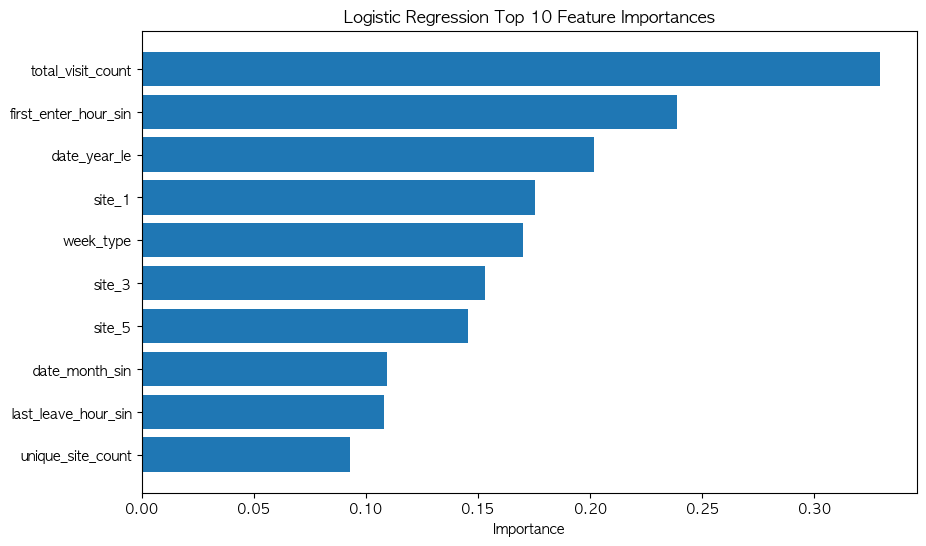

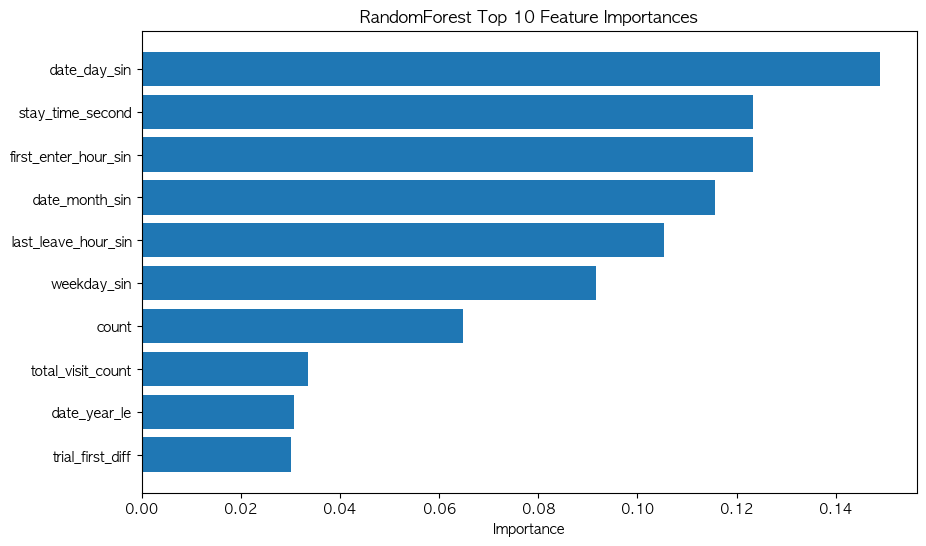

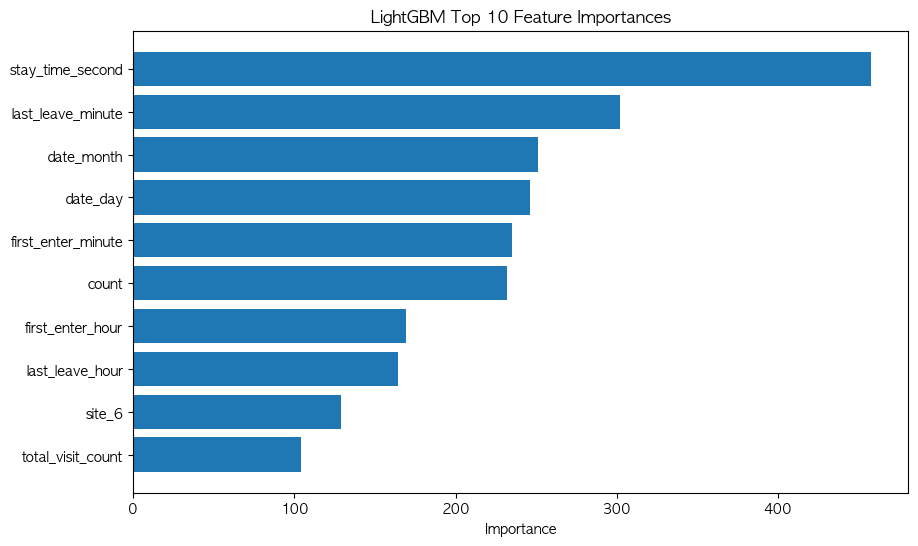

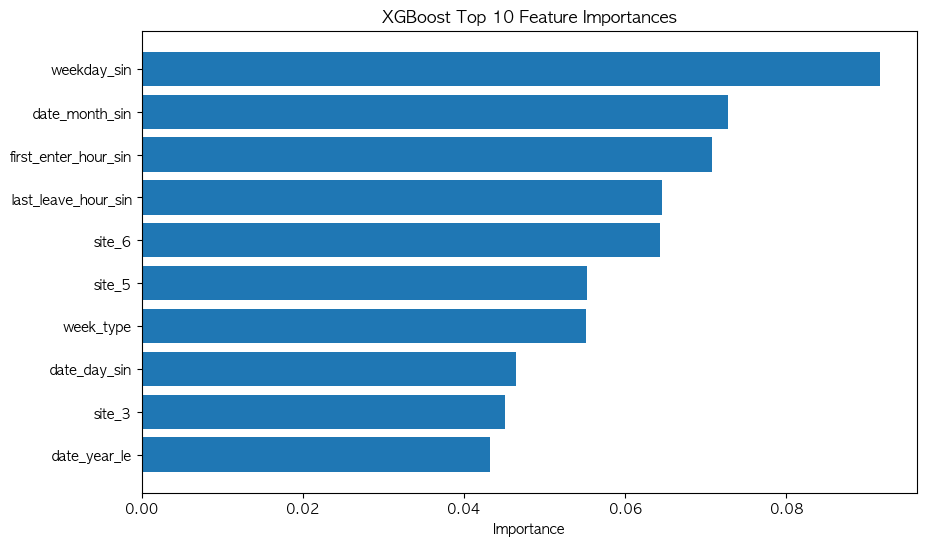

In [116]:
# 옵션: 피처 중요도 시각화 - 로지스틱 회귀
lr_df_sorted = lr_df.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(lr_df_sorted['Feature'][::-1], lr_df_sorted['Importance'][::-1])
plt.xlabel("Importance")
plt.title("Logistic Regression Top 10 Feature Importances")
plt.show()

# 옵션: 피처 중요도 시각화 - 랜덤포레스트
rf_df_sorted = rf_df.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(rf_df_sorted['Feature'][::-1], rf_df_sorted['Importance'][::-1])
plt.xlabel("Importance")
plt.title("RandomForest Top 10 Feature Importances")
plt.show()

# 옵션: 피처 중요도 시각화 - LightGBM
lgbm_df_sorted = lgbm_df.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(lgbm_df_sorted['Feature'][::-1], lgbm_df_sorted['Importance'][::-1])
plt.xlabel("Importance")
plt.title("LightGBM Top 10 Feature Importances")
plt.show()

# 옵션: 피처 중요도 시각화 - XGBoost
xgb_df_sorted = xgb_df.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(xgb_df_sorted['Feature'][::-1], xgb_df_sorted['Importance'][::-1])
plt.xlabel("Importance")
plt.title("XGBoost Top 10 Feature Importances")
plt.show()


### 그리드서치

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from imblearn.combine import SMOTETomek
# from sklearn.metrics import average_precision_score, accuracy_score
# from sklearn.ensemble import RandomForestClassifier
# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier


# X = df_2.drop(columns=['is_payment'])
# y = df_2['is_payment']

# # 학습/테스트셋 분할 (stratify로 클래스 비율을 유지)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# # SMOTETomek 객체 생성 및 학습셋에만 오버샘플링/언더샘플링 적용
# smt = SMOTETomek(random_state=42)
# X_train_over, y_train_over = smt.fit_resample(X_train, y_train)

# # 결과 확인
# print("오버샘플링 전 학습 데이터 크기:", X_train.shape)
# print("오버샘플링 후 학습 데이터 크기:", X_train_over.shape)
# print("오버샘플링 전 타겟 크기:", y_train.shape)
# print("오버샘플링 후 타겟 크기:", y_train_over.shape)


# # RandomForest 모델 학습
# rf_param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5]
# }
# rf_clf = RandomForestClassifier(random_state=42)
# rf_grid = GridSearchCV(estimator=rf_clf, 
#                        param_grid=rf_param_grid, 
#                        scoring='average_precision', 
#                        cv=3, 
#                        n_jobs=-1)
# rf_grid.fit(X_train_over, y_train_over)
# best_rf = rf_grid.best_estimator_
# y_pred_rf_prob = best_rf.predict_proba(X_test)[:, 1]
# aucpr_rf = average_precision_score(y_test, y_pred_rf_prob)
# y_pred_rf = best_rf.predict(X_test)
# accuracy_rf = accuracy_score(y_test, y_pred_rf)
# print("RandomForest Best Params:", rf_grid.best_params_)
# print("RandomForest AUC-PR:", aucpr_rf)
# print("RandomForest Accuracy:", accuracy_rf)


# # LightGBM 모델 학습
# lgbm_param_grid = {
#     'n_estimators': [100, 200],
#     'num_leaves': [31, 50],
#     'learning_rate': [0.1, 0.01],
#     'max_depth': [None, 10, 20]
# }
# lgbm_clf = LGBMClassifier(random_state=42)
# lgbm_grid = GridSearchCV(estimator=lgbm_clf, 
#                          param_grid=lgbm_param_grid, 
#                          scoring='average_precision', 
#                          cv=3, 
#                          n_jobs=-1)
# lgbm_grid.fit(X_train_over, y_train_over)
# best_lgbm = lgbm_grid.best_estimator_
# y_pred_lgbm_prob = best_lgbm.predict_proba(X_test)[:, 1]
# aucpr_lgbm = average_precision_score(y_test, y_pred_lgbm_prob)
# y_pred_lgbm = best_lgbm.predict(X_test)
# accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
# print("LightGBM Best Params:", lgbm_grid.best_params_)
# print("LightGBM AUC-PR:", aucpr_lgbm)
# print("LightGBM Accuracy:", accuracy_lgbm)


# # XGBoost 모델 학습
# xgb_param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 6, 10],
#     'learning_rate': [0.1, 0.01],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }
# xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# xgb_grid = GridSearchCV(estimator=xgb_clf, 
#                         param_grid=xgb_param_grid, 
#                         scoring='average_precision', 
#                         cv=3, 
#                         n_jobs=-1)
# xgb_grid.fit(X_train_over, y_train_over)
# best_xgb = xgb_grid.best_estimator_
# y_pred_xgb_prob = best_xgb.predict_proba(X_test)[:, 1]
# aucpr_xgb = average_precision_score(y_test, y_pred_xgb_prob)
# y_pred_xgb = best_xgb.predict(X_test)
# accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
# print("XGBoost Best Params:", xgb_grid.best_params_)
# print("XGBoost AUC-PR:", aucpr_xgb)
# print("XGBoost Accuracy:", accuracy_xgb)


# # Best model output
# models = {
#     "RandomForest": {"model": best_rf, "AUC-PR": aucpr_rf, "Accuracy": accuracy_rf},
#     "LightGBM": {"model": best_lgbm, "AUC-PR": aucpr_lgbm, "Accuracy": accuracy_lgbm},
#     "XGBoost": {"model": best_xgb, "AUC-PR": aucpr_xgb, "Accuracy": accuracy_xgb}
# }

# best_model = max(models, key=lambda x: models[x]["AUC-PR"])  # AUC-PR 기준 최적 모델 선정
# print(f"Best model based on AUC-PR: {best_model}")
# print(f"Best model AUC-PR: {models[best_model]['AUC-PR']}")
# print(f"Best model Accuracy: {models[best_model]['Accuracy']}")


오버샘플링 전 학습 데이터 크기: (8436, 31)
오버샘플링 후 학습 데이터 크기: (7672, 31)
오버샘플링 전 타겟 크기: (8436,)
오버샘플링 후 타겟 크기: (7672,)
RandomForest Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
RandomForest AUC-PR: 0.5151330066299491
RandomForest Accuracy: 0.6170616113744076
[LightGBM] [Info] Number of positive: 2558, number of negative: 2557
[LightGBM] [Info] Number of positive: 2558, number of negative: 2557
[LightGBM] [Info] Number of positive: 2557, number of negative: 2557
[LightGBM] [Info] Number of positive: 2557, number of negative: 2557
[LightGBM] [Info] Number of positive: 2557, number of negative: 2557
[LightGBM] [Info] Number of positive: 2557, number of negative: 2558
[LightGBM] [Info] Number of positive: 2557, number of negative: 2558
[LightGBM] [Info] Number of positive: 2557, number of negative: 2557
[LightGBM] [Info] Number of positive: 2557, number of negative: 2558
[LightGBM] [Info] Number of positive: 2558, number of negative: 2557
[LightGBM] [Info] Auto-choosing r

/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:44:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:44:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:44:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:44:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt

XGBoost Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}
XGBoost AUC-PR: 0.5237167309306188
XGBoost Accuracy: 0.6274881516587678
Best model based on AUC-PR: XGBoost
Best model AUC-PR: 0.5237167309306188
Best model Accuracy: 0.6274881516587678


### Auto ML

In [99]:
time_df = pd.read_csv('/Users/parkjunhyeok/Desktop/codit/프로젝트/중급2프로젝트/meger_df_컬럼추가.csv',index_col=False)

In [100]:
time_df.columns

Index(['site_id', 'date', 'stay_time_second', 'first_enter_time',
       'last_leave_time', 'user_uuid', 'trial_date', 'is_payment', 'count',
       'date_year', 'date_month', 'date_day', 'weekday', 'week_type',
       'first_visit_date', 'trial_first_diff', 'first_enter_hour',
       'first_enter_minute', 'last_leave_hour', 'last_leave_minute',
       'unique_site_count', 'total_visit_count', 'area_pyeong'],
      dtype='object')

In [101]:
# 4. first_enter_time과 last_leave_time을 datetime 타입으로 변환
def parse_mixed_datetime(x):
    # 마이크로초가 포함된 형식 먼저 시도
    try:
        return pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f")
    except ValueError:
        # 마이크로초가 없는 형식으로 변환 시도
        return pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S")

# 각 컬럼에 대해 변환 적용
time_df['first_enter_time'] = time_df['first_enter_time'].apply(parse_mixed_datetime)
time_df['last_leave_time'] = time_df['last_leave_time'].apply(parse_mixed_datetime)


# 개선된 코드 
df_filtered = time_df[~((time_df['first_enter_time'].dt.hour < 6) & (time_df['last_leave_time'].dt.hour >= 2) |(time_df['first_enter_time'].dt.hour.between(2, 6, inclusive='left')) | (time_df['last_leave_time'].dt.hour.between(2, 6, inclusive='left')) | ((time_df['first_enter_time'].dt.hour < 2) & (time_df['last_leave_time'].dt.hour >= 6)))]



In [102]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9868 entries, 0 to 10559
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   site_id             9868 non-null   int64         
 1   date                9868 non-null   object        
 2   stay_time_second    9868 non-null   int64         
 3   first_enter_time    9868 non-null   datetime64[ns]
 4   last_leave_time     9868 non-null   datetime64[ns]
 5   user_uuid           9868 non-null   object        
 6   trial_date          9868 non-null   object        
 7   is_payment          9868 non-null   int64         
 8   count               9868 non-null   float64       
 9   date_year           9868 non-null   int64         
 10  date_month          9868 non-null   int64         
 11  date_day            9868 non-null   int64         
 12  weekday             9868 non-null   int64         
 13  week_type           9868 non-null   int64         
 

In [103]:
df_filtered.isnull().sum()

site_id               0
date                  0
stay_time_second      0
first_enter_time      0
last_leave_time       0
user_uuid             0
trial_date            0
is_payment            0
count                 0
date_year             0
date_month            0
date_day              0
weekday               0
week_type             0
first_visit_date      0
trial_first_diff      0
first_enter_hour      0
first_enter_minute    0
last_leave_hour       0
last_leave_minute     0
unique_site_count     0
total_visit_count     0
area_pyeong           0
dtype: int64

In [104]:
unique_hours = df_filtered['first_enter_time'].dt.hour.unique()
print(unique_hours)


[16 10 14 15 13 12  9  8 18 17 20 19 11 22  0 21  7 23  6  1]


In [105]:
df_filtered.columns

Index(['site_id', 'date', 'stay_time_second', 'first_enter_time',
       'last_leave_time', 'user_uuid', 'trial_date', 'is_payment', 'count',
       'date_year', 'date_month', 'date_day', 'weekday', 'week_type',
       'first_visit_date', 'trial_first_diff', 'first_enter_hour',
       'first_enter_minute', 'last_leave_hour', 'last_leave_minute',
       'unique_site_count', 'total_visit_count', 'area_pyeong'],
      dtype='object')

In [106]:
import numpy as np
import pandas as pd

# 1. site_id 원핫 인코딩: 
#    (원본 merge_df에 새로운 컬럼들을 추가하는 대신, get_dummies를 사용하여 site_id를 더미 변수로 만듭니다.)
df = pd.get_dummies(df_filtered, columns=['site_id'], prefix='site')

# 2. date_year 컬럼에 대해 레이블 인코딩 적용 (사이클릭 인코딩 대신)
#    예: 2022 -> 0, 2023 -> 1, ... 등으로 매핑됨
df['date_year_le'] = df['date_year'].astype('category').cat.codes

# 2. 사이클릭 인코딩 함수 정의:
def add_cyclic_features(df, col, period):
    """
    df: 데이터프레임
    col: 사이클릭 인코딩을 적용할 컬럼명 (숫자형이어야 함)
    period: 해당 컬럼의 주기 (예: month는 12, hour는 24 등)
    """
    sin_col = col + '_sin'
    cos_col = col + '_cos'
    df[sin_col] = np.sin(2 * np.pi * df[col] / period)
    df[cos_col] = np.cos(2 * np.pi * df[col] / period)
    return df

# 3. 각 컬럼에 대해 사이클릭 인코딩 적용

# date_month: 12개월 주기
df = add_cyclic_features(df, 'date_month', 12)

# date_day: 일반적으로 한 달 최대 31일이므로
df = add_cyclic_features(df, 'date_day', 31)

# first_enter_hour: 24시간 주기
df = add_cyclic_features(df, 'first_enter_hour', 24)

# first_enter_minute: 60분 주기
df = add_cyclic_features(df, 'first_enter_minute', 60)

# last_leave_hour: 24시간 주기
df = add_cyclic_features(df, 'last_leave_hour', 24)

# last_leave_minute: 60분 주기
df = add_cyclic_features(df, 'last_leave_minute', 60)

# 결과 확인
print(df.head())


         date  stay_time_second           first_enter_time  \
0  2023-12-23              4279 2023-12-23 16:11:25.345793   
1  2023-12-24             16510 2023-12-24 16:10:45.668026   
2  2023-12-25              7794 2023-12-25 10:19:47.087268   
3  2023-12-23             16656 2023-12-23 14:49:40.302823   
4  2023-12-26             16325 2023-12-26 14:57:10.220793   

             last_leave_time                             user_uuid  \
0 2023-12-23 17:25:32.233995  939fc566-61cd-47f0-a3ce-e2936fdcff73   
1 2023-12-24 20:53:34.842447  939fc566-61cd-47f0-a3ce-e2936fdcff73   
2 2023-12-25 12:39:51.221372  939fc566-61cd-47f0-a3ce-e2936fdcff73   
3 2023-12-23 19:27:39.406803  ba49324f-d317-4053-adf9-2b17b3f07594   
4 2023-12-26 19:34:36.971542  ba49324f-d317-4053-adf9-2b17b3f07594   

   trial_date  is_payment  count  date_year  date_month  date_day  weekday  \
0  2023-12-23           1    4.0       2023          12        23        5   
1  2023-12-23           1    8.0       2023       

In [107]:
df.columns

Index(['date', 'stay_time_second', 'first_enter_time', 'last_leave_time',
       'user_uuid', 'trial_date', 'is_payment', 'count', 'date_year',
       'date_month', 'date_day', 'weekday', 'week_type', 'first_visit_date',
       'trial_first_diff', 'first_enter_hour', 'first_enter_minute',
       'last_leave_hour', 'last_leave_minute', 'unique_site_count',
       'total_visit_count', 'area_pyeong', 'site_1', 'site_2', 'site_3',
       'site_4', 'site_5', 'site_6', 'site_17', 'site_47', 'site_49',
       'date_year_le', 'date_month_sin', 'date_month_cos', 'date_day_sin',
       'date_day_cos', 'first_enter_hour_sin', 'first_enter_hour_cos',
       'first_enter_minute_sin', 'first_enter_minute_cos',
       'last_leave_hour_sin', 'last_leave_hour_cos', 'last_leave_minute_sin',
       'last_leave_minute_cos'],
      dtype='object')

In [108]:

# drop
df = df.drop(columns=['last_leave_minute_cos','first_enter_minute_cos','user_uuid','first_enter_time','last_leave_time','trial_date','date_year','date_month','date_day'],axis=1)

df.columns

Index(['date', 'stay_time_second', 'is_payment', 'count', 'weekday',
       'week_type', 'first_visit_date', 'trial_first_diff', 'first_enter_hour',
       'first_enter_minute', 'last_leave_hour', 'last_leave_minute',
       'unique_site_count', 'total_visit_count', 'area_pyeong', 'site_1',
       'site_2', 'site_3', 'site_4', 'site_5', 'site_6', 'site_17', 'site_47',
       'site_49', 'date_year_le', 'date_month_sin', 'date_month_cos',
       'date_day_sin', 'date_day_cos', 'first_enter_hour_sin',
       'first_enter_hour_cos', 'first_enter_minute_sin', 'last_leave_hour_sin',
       'last_leave_hour_cos', 'last_leave_minute_sin'],
      dtype='object')

In [109]:
df.columns

Index(['date', 'stay_time_second', 'is_payment', 'count', 'weekday',
       'week_type', 'first_visit_date', 'trial_first_diff', 'first_enter_hour',
       'first_enter_minute', 'last_leave_hour', 'last_leave_minute',
       'unique_site_count', 'total_visit_count', 'area_pyeong', 'site_1',
       'site_2', 'site_3', 'site_4', 'site_5', 'site_6', 'site_17', 'site_47',
       'site_49', 'date_year_le', 'date_month_sin', 'date_month_cos',
       'date_day_sin', 'date_day_cos', 'first_enter_hour_sin',
       'first_enter_hour_cos', 'first_enter_minute_sin', 'last_leave_hour_sin',
       'last_leave_hour_cos', 'last_leave_minute_sin'],
      dtype='object')

In [110]:
df.drop(columns=['date','first_visit_date','first_enter_hour','first_enter_minute','last_leave_hour','last_leave_minute'],axis=1,inplace=True)

In [111]:
len(df.columns)

29

In [112]:
pd.set_option('display.max_columns', None)
df.head()

,stay_time_second,is_payment,count,weekday,week_type,trial_first_diff,unique_site_count,total_visit_count,area_pyeong,site_1,site_2,site_3,site_4,site_5,site_6,site_17,site_47,site_49,date_year_le,date_month_sin,date_month_cos,date_day_sin,date_day_cos,first_enter_hour_sin,first_enter_hour_cos,first_enter_minute_sin,last_leave_hour_sin,last_leave_hour_cos,last_leave_minute_sin
0,4279,1,4.0,5,1,0,1,3,50,True,False,False,False,False,False,False,False,False,2,-2.449294e-16,1.0,-0.998717,-0.050649,-0.866025,-0.500000,0.913545,-9.659258e-01,-0.258819,0.500000
1,16510,1,8.0,6,1,0,1,3,50,True,False,False,False,False,False,False,False,False,2,-2.449294e-16,1.0,-0.988468,0.151428,-0.866025,-0.500000,0.866025,-8.660254e-01,0.500000,-0.669131
2,7794,1,6.0,0,0,0,1,3,50,True,False,False,False,False,False,False,False,False,2,-2.449294e-16,1.0,-0.937752,0.347305,0.500000,-0.866025,0.913545,1.224647e-16,-1.000000,-0.809017
3,16656,1,4.0,5,1,0,3,3,50,True,False,False,False,False,False,False,False,False,2,-2.449294e-16,1.0,-0.998717,-0.050649,-0.500000,-0.866025,-0.913545,-9.659258e-01,0.258819,0.309017
4,16325,1,6.0,1,0,0,3,3,150,False,False,True,False,False,False,False,False,False,2,-2.449294e-16,1.0,-0.848644,0.528964,-0.500000,-0.866025,-0.309017,-9.659258e-01,0.258819,-0.406737


In [113]:
df.drop(columns=['first_enter_minute_sin','last_leave_minute_sin','last_leave_hour_cos','first_enter_hour_cos'],axis=1,inplace=True)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9868 entries, 0 to 10559
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stay_time_second      9868 non-null   int64  
 1   is_payment            9868 non-null   int64  
 2   count                 9868 non-null   float64
 3   weekday               9868 non-null   int64  
 4   week_type             9868 non-null   int64  
 5   trial_first_diff      9868 non-null   int64  
 6   unique_site_count     9868 non-null   int64  
 7   total_visit_count     9868 non-null   int64  
 8   area_pyeong           9868 non-null   int64  
 9   site_1                9868 non-null   bool   
 10  site_2                9868 non-null   bool   
 11  site_3                9868 non-null   bool   
 12  site_4                9868 non-null   bool   
 13  site_5                9868 non-null   bool   
 14  site_6                9868 non-null   bool   
 15  site_17               986

In [115]:
# last_leave_minute: 7분 주기
df = add_cyclic_features(df, 'weekday', 7)
df.drop(columns=['weekday'],axis=1,inplace=True)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9868 entries, 0 to 10559
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stay_time_second      9868 non-null   int64  
 1   is_payment            9868 non-null   int64  
 2   count                 9868 non-null   float64
 3   week_type             9868 non-null   int64  
 4   trial_first_diff      9868 non-null   int64  
 5   unique_site_count     9868 non-null   int64  
 6   total_visit_count     9868 non-null   int64  
 7   area_pyeong           9868 non-null   int64  
 8   site_1                9868 non-null   bool   
 9   site_2                9868 non-null   bool   
 10  site_3                9868 non-null   bool   
 11  site_4                9868 non-null   bool   
 12  site_5                9868 non-null   bool   
 13  site_6                9868 non-null   bool   
 14  site_17               9868 non-null   bool   
 15  site_47               986

In [117]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.metrics import average_precision_score, confusion_matrix, classification_report

# 타겟변수와 입력 변수 정의 (여기서는 is_payment가 타겟이라고 가정)
X = df.drop(columns=['is_payment'])
y = df['is_payment']

# 학습/테스트셋으로 분할 (stratify 옵션 사용하여 클래스 분포 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# # SMOTETomek 객체 생성 및 오버샘플링/언더샘플링 적용 (train 데이터에만 적용)
# smt = SMOTETomek(random_state=42)
# X_train_over, y_train_over = smt.fit_resample(X_train, y_train)

# SMOTETomek 객체 생성 및 오버샘플링/언더샘플링 적용 (train 데이터에만 적용)
smt = SMOTE(random_state=42)
X_train_over, y_train_over = smt.fit_resample(X_train, y_train)

# 결과 확인
print("오버샘플링 전 X_train 데이터 크기:", X_train.shape)
print("오버샘플링 후 X_train 데이터 크기:", X_train_over.shape)
print("오버샘플링 전 y_train 데이터 크기:", y_train.shape)
print("오버샘플링 후 y_train 데이터 크기:", y_train_over.shape)

### Logistic Regression ###
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train_over, y_train_over)

# 예측 확률 (양성 클래스 확률)
y_pred_lr_prob = lr_clf.predict_proba(X_test)[:, 1]
aucpr_lr = average_precision_score(y_test, y_pred_lr_prob)

# 예측 클래스 (혼동행렬 및 리포트를 위한 예측 결과)
y_pred_lr = lr_clf.predict(X_test)

print("Logistic Regression AUC-PR:", aucpr_lr)
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

### RandomForestClassifier ###
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_over, y_train_over)

# 예측 확률 (양성 클래스 확률)
y_pred_rf_prob = rf_clf.predict_proba(X_test)[:, 1]
aucpr_rf = average_precision_score(y_test, y_pred_rf_prob)

# 예측 클래스 (혼동행렬 및 리포트를 위한 예측 결과)
y_pred_rf = rf_clf.predict(X_test)

print("RandomForest AUC-PR:", aucpr_rf)
print("RandomForest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("RandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf))

### LightGBM Classifier ###
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(random_state=42)
lgbm_clf.fit(X_train_over, y_train_over)
y_pred_lgbm_prob = lgbm_clf.predict_proba(X_test)[:, 1]
aucpr_lgbm = average_precision_score(y_test, y_pred_lgbm_prob)
y_pred_lgbm = lgbm_clf.predict(X_test)

print("LightGBM AUC-PR:", aucpr_lgbm)
print("LightGBM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm))
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

### XGBoost Classifier ###
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_over, y_train_over)
y_pred_xgb_prob = xgb_clf.predict_proba(X_test)[:, 1]
aucpr_xgb = average_precision_score(y_test, y_pred_xgb_prob)
y_pred_xgb = xgb_clf.predict(X_test)

print("XGBoost AUC-PR:", aucpr_xgb)
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

### CatBoost Classifier ###
from catboost import CatBoostClassifier
cat_clf = CatBoostClassifier(random_state=42, verbose=0)
cat_clf.fit(X_train_over, y_train_over)
y_pred_cat_prob = cat_clf.predict_proba(X_test)[:, 1]
aucpr_cat = average_precision_score(y_test, y_pred_cat_prob)
y_pred_cat = cat_clf.predict(X_test)

print("CatBoost AUC-PR:", aucpr_cat)
print("CatBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_cat))
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))


오버샘플링 전 X_train 데이터 크기: (7894, 25)
오버샘플링 후 X_train 데이터 크기: (9338, 25)
오버샘플링 전 y_train 데이터 크기: (7894,)
오버샘플링 후 y_train 데이터 크기: (9338,)


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression AUC-PR: 0.4659063276123905
Logistic Regression Confusion Matrix:
[[656 512]
 [350 456]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.56      0.60      1168
           1       0.47      0.57      0.51       806

    accuracy                           0.56      1974
   macro avg       0.56      0.56      0.56      1974
weighted avg       0.58      0.56      0.57      1974

RandomForest AUC-PR: 0.5472708612169535
RandomForest Confusion Matrix:
[[902 266]
 [461 345]]
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.77      0.71      1168
           1       0.56      0.43      0.49       806

    accuracy                           0.63      1974
   macro avg       0.61      0.60      0.60      1974
weighted avg       0.62      0.63      0.62      1974

[LightGBM] [Info] Number of positive: 4669, number of negative: 4

/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:32:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost AUC-PR: 0.5526836802989274
XGBoost Confusion Matrix:
[[861 307]
 [438 368]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.74      0.70      1168
           1       0.55      0.46      0.50       806

    accuracy                           0.62      1974
   macro avg       0.60      0.60      0.60      1974
weighted avg       0.61      0.62      0.62      1974

CatBoost AUC-PR: 0.5767481865141937
CatBoost Confusion Matrix:
[[917 251]
 [462 344]]
CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.79      0.72      1168
           1       0.58      0.43      0.49       806

    accuracy                           0.64      1974
   macro avg       0.62      0.61      0.61      1974
weighted avg       0.63      0.64      0.63      1974

